In [ ]:
! pip install sklearn
! pip install seaborn
! pip install matplotlib
! pip install cvxopt

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

# Собственная реализация

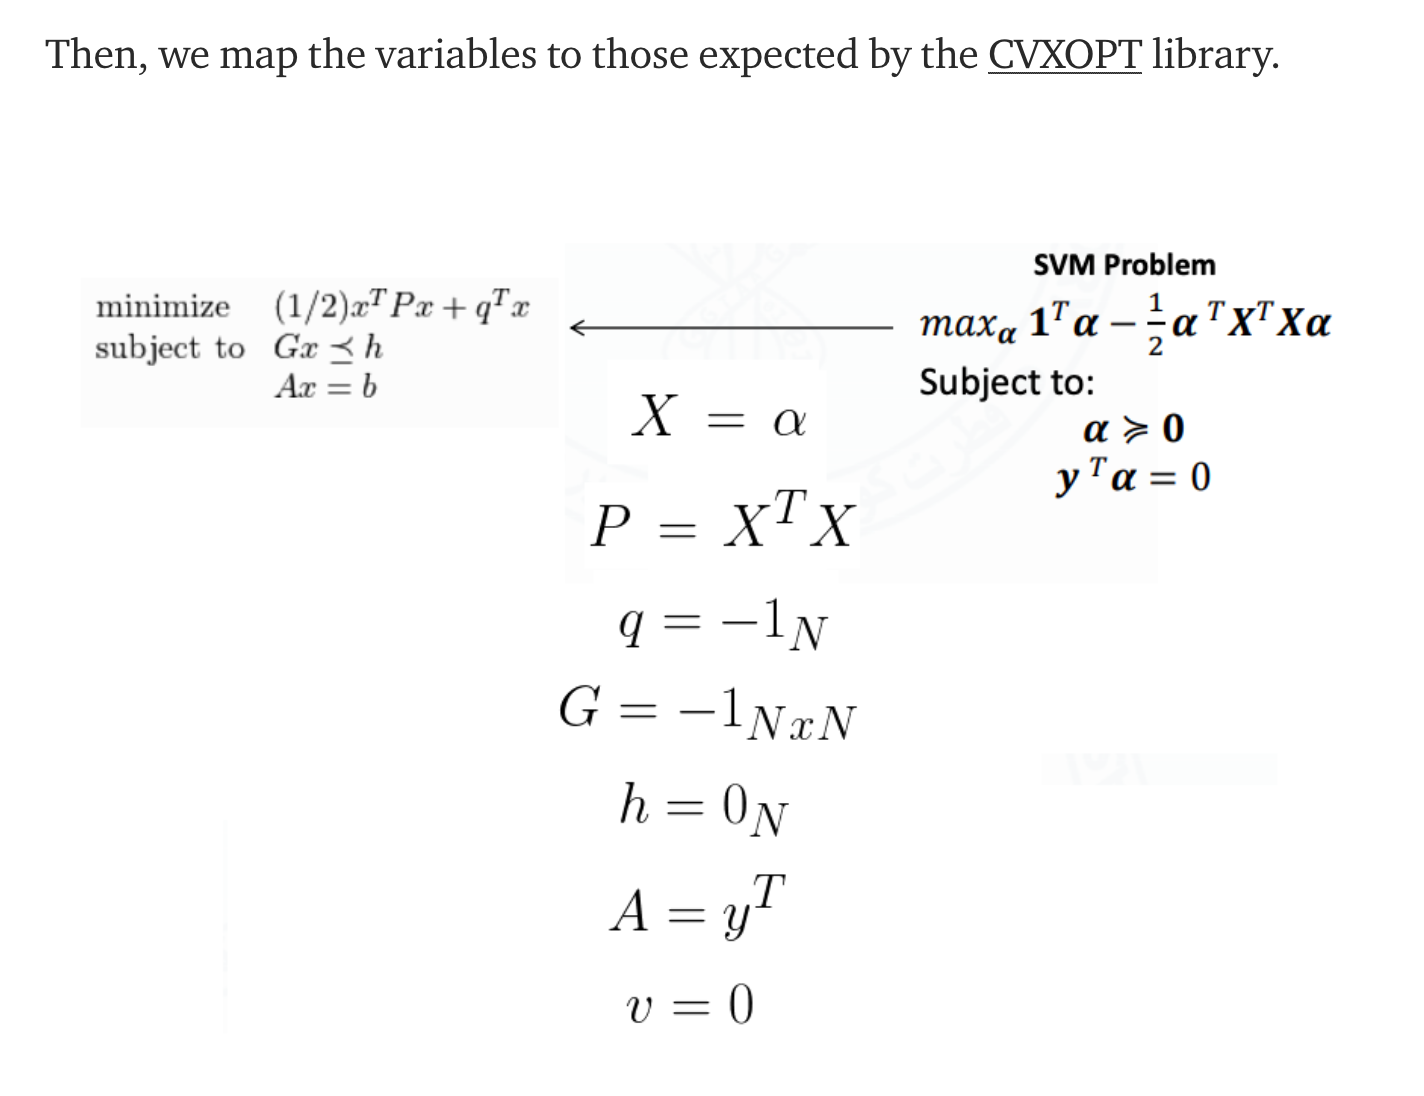

In [2]:
from IPython.display import Image
Image("/Users/d.merkushov/Desktop/conv.png")

In [ ]:
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.6)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [ ]:
class LinearSVM():
    def __init__(self, C=1, gamma=1):
        self._C = C
        self._gamma = gamma
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        # P = X^T X
        P = cvxopt.matrix(np.outer(y, y) * K)
        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -self._C)
        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
        # b = 0 
        b = cvxopt.matrix(0.0)
        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
        # Множители Лагранжа
        a = np.ravel(solution['x'])
        
        self.a = None
        self.sv = None
        self.sv_y = None

        self.b = None
        self.w = None
    
    def project(self, X):
        return None

    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot(self, X):
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 30)
        y = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
        X_, Y_ = np.meshgrid(y, x)

        xy = np.vstack([X_.ravel(), Y_.ravel()]).T
        P = self.project(xy).reshape(X_.shape)

        # plot decision boundary and margins
        ax.contour(X_, Y_, P, colors='k',
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
svm = LinearSVM(C=1)
svm.fit(X_train, y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
svm.plot(X_train)

In [ ]:
pred = svm.predict(X_test)
target = y_test

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print classification_report(target, pred)

# Нелинейный случай

In [ ]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
svm = LinearSVM(C=1)
svm.fit(X_train, y_train)

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
svm.plot(X_train)

## Kernel SVM

In [ ]:
class KernelSVM:
    def __init__(self, C=1, ker='rbf', gamma=1):
        self._C = C
        self._Ker = self.linear
        if ker=='rbf': self._Ker = self.rbf
        self._gamma = gamma
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        # P = X^T X
        P = cvxopt.matrix(np.outer(y, y) * K)
        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -self._C)
        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
        # b = 0 
        b = cvxopt.matrix(0.0)
        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
        # Множители Лагранжа
        a = np.ravel(solution['x'])
        
        self.a = None
        self.sv = None
        self.sv_y = None

        self.b = None
        self.w = None
    
    def rbf(self, x, y):
        if len(x.shape) > 1:
            return np.exp(-np.diagonal(np.dot(x-y, (x-y).T)) * self._gamma)
        else: 
            return np.exp(-(np.dot(x-y, (x-y).T)))
        
    def linear(self, x, y):
        return np.dot(x, y.T)
    
    def project(self, X):
        sum = 0
        for n in range(len(self.a)):
            sum += self.a[n] * self.sv_y[n] * self._Ker(X, self.sv[n])
        return sum + self.b

    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot(self, X):
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 30)
        y = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
        X_, Y_ = np.meshgrid(y, x)

        xy = np.vstack([X_.ravel(), Y_.ravel()]).T
        P = self.project(xy).reshape(X_.shape)

        # plot decision boundary and margins
        ax.contour(X_, Y_, P, colors='k',
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
svm = KernelSVM(C=1, ker='rbf',gamma=5)
svm.fit(X_train, y_train)

svm.plot(X)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')

In [ ]:
pred = svm.predict(X_test)
target = y_test

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print classification_report(target, pred)

# SVM как качественный классификатор

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

In [ ]:
plt.imshow(faces.images[0], cmap='bone')

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [ ]:
X = faces.data
y = faces.target

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=42)

In [ ]:
from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

In [ ]:
pred = svm.predict(X_test)
target = y_test

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print classification_report(target, pred)

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=42)

from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150,whiten=True)
pca.fit(faces.data)
X = pca.transform(faces.data)

In [ ]:
X.shape

In [ ]:
y = faces.target

In [ ]:
import random
test_frac = 0.3
num = len(X) * test_frac
ids_test = np.random.choice(xrange(len(X)), int(num))

In [ ]:
ids_train = set(np.arange(len(X))) - set(ids_test)
ids_train = np.array(list(ids_train))
print len(ids_train), len(ids_test)

In [ ]:
X_train = X[ids_train]
y_train = faces.target[ids_train]
X_test = X[ids_test]
y_test = faces.target[ids_test]

In [ ]:
from sklearn.svm import SVC
svm = SVC(C=1, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target, pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Draw Misclassification

In [ ]:
mask = np.logical_and(pred==3, target==1)
ids_misclf = ids_test[mask]

In [ ]:
pic = faces.images[ids_misclf[1]]
plt.imshow(pic, cmap='bone')

## Self kernelSVM

In [ ]:
y = faces.target == 1
y = np.array([1. if j else -1. for j in y])

In [ ]:
X_train = X[ids_train]
y_train = y[ids_train]
X_test = X[ids_test]
y_test = y[ids_test]

In [ ]:
svm = KernelSVM(C=10, gamma=0.001, ker='rbf')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)

# Cross Validation

In [ ]:
y = faces.target

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, y_train = None, None
X_test, y_test = None, None
X_val, y_val = None, None

In [ ]:
import itertools

best_model = None
best_f1 = 0
best_params = None

grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

for c,gamma in itertools.product(grid['C'], grid['gamma']):
    pass

In [ ]:
best_params

In [ ]:
pred = best_model.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)